# 1. Load Data

In [1]:
import pickle
import numpy as np
import os

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Define file paths
data_dir = './data/'  # Directory where data is located
train_files = [f"data_batch_{i}" for i in range(1, 6)]
test_file = "test_batch"

# Load training data
train_data = []
train_labels = []

for file in train_files:
    data_dict = unpickle(os.path.join(data_dir, file))
    train_data.append(data_dict[b'data'])
    train_labels += data_dict[b'labels']

train_data = np.concatenate(train_data)
train_data = train_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) # Convert to (N, H, W, C) format
train_labels = np.array(train_labels)

# Load test data
test_dict = unpickle(os.path.join(data_dir, test_file))
test_data = test_dict[b'data']
test_data = test_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
test_labels = np.array(test_dict[b'labels'])

print(np.shape(train_data))

(50000, 32, 32, 3)


In [2]:
# Load class names
meta = unpickle(os.path.join(data_dir, "batches.meta"))
label_names = [label.decode('utf-8') for label in meta[b'label_names']]
print("Label Names:", label_names)

Label Names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# 2. Normalise data & Split Datasets

In [3]:
# Calculate the mean and standard deviation for each channel
mean = np.mean(train_data/255.0, axis=(0, 1, 2))  # Mean for each channel (R, G, B)
std = np.std(train_data/255.0, axis=(0, 1, 2))    # Standard deviation for each channel (R, G, B)
print("Mean:", mean)
print("Standard Deviation:", std)

Mean: [0.49139968 0.48215841 0.44653091]
Standard Deviation: [0.24703223 0.24348513 0.26158784]


In [4]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42) # Ensures that the random number sequence generated with torch is repeatable

# Define device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)  # if use multi gpus

# Normalize using calculated mean and standard deviation
# Define a transformation that normalizes using the calculated mean and std
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to tensor and scales values to [0, 1]
    transforms.Normalize(mean.tolist(), std.tolist())  # Normalize based on calculated mean and std
])

# Apply transformation to each image in train and test sets, ensuring float32 dtype
train_data_tensor = torch.stack([transform(train_data[i]) for i in range(len(train_data))]).to(device)
test_data_tensor = torch.stack([transform(test_data[i]) for i in range(len(test_data))]).to(device)

# Convert labels to tensor and move data to device
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long).to(device)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long).to(device)

# Wrap as PyTorch datasets
train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)

# Define the total length of the training set
total_train_size = len(train_dataset)

# Calculate 80% and 20% of the data size
train_size = int(0.8 * total_train_size)
val_size = total_train_size - train_size

# Randomly split the dataset
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

#-----------------------------------------------------------------#

# DataLoader is used to load data in batches
trainloader = DataLoader(train_subset, batch_size=512, shuffle=True)
valloader = DataLoader(val_subset, batch_size=1024, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

print(f"Total training samples: {train_size}")
print(f"Total validation samples: {val_size}")
print(f"Total test samples: {len(test_dataset)}")

# Verify the shape and type of data
print("Train data shape:", train_data_tensor.shape, "dtype:", train_data_tensor.dtype)
print("Test data shape:", test_data_tensor.shape, "dtype:", test_data_tensor.dtype)
print("Train labels shape:", train_labels_tensor.shape, "dtype:", train_labels_tensor.dtype)
print("Test labels shape:", test_labels_tensor.shape, "dtype:", test_labels_tensor.dtype)

Using device: cuda
Total training samples: 40000
Total validation samples: 10000
Total test samples: 10000
Train data shape: torch.Size([50000, 3, 32, 32]) dtype: torch.float32
Test data shape: torch.Size([10000, 3, 32, 32]) dtype: torch.float32
Train labels shape: torch.Size([50000]) dtype: torch.int64
Test labels shape: torch.Size([10000]) dtype: torch.int64


# 3. ResNet-18 Model Training

## a. Load ResNet-18

In [5]:
# Load Dependencies
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt

In [6]:
# Function to initialize baseline model, optimizer, and criterion
def initialize_model(lr=0.001, weight_decay=0):
    model = models.resnet18(weights=None)  # No pretrained weights
    model.fc = nn.Linear(model.fc.in_features, 10)  # CIFAR-10 has 10 classes
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    return model, optimizer, criterion

## b. Define training and validate functions

In [7]:
# Function to train one epoch
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Function to validate model
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

## c. Plot Loss curve ans accuracy

In [24]:
import os

# Function to plot and save metrics with academic-style formatting and high resolution
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, title_prefix, save_dir="plots", dpi=300):
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Set font to Times New Roman
    plt.rcParams['font.family'] = 'Times New Roman'
    
    # Create the figure
    plt.figure(figsize=(12, 5))
    
    # Plot Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', linestyle='-', marker='o', markersize=5)
    plt.plot(val_losses, label='Validation Loss', linestyle='-', marker='s', markersize=5)
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    plt.ylim(0, max(max(train_losses), max(val_losses)) * 1.1)
    plt.legend(fontsize=16)
    plt.title(f'{title_prefix} Loss Curve', fontsize=22)
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Plot Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy', linestyle='-', marker='o', markersize=5)
    plt.plot(val_accuracies, label='Validation Accuracy', linestyle='-', marker='s', markersize=5)
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel('Accuracy (%)', fontsize=18)
    plt.ylim(0, 100)
    plt.legend(fontsize=16)
    plt.title(f'{title_prefix} Accuracy Curve', fontsize=22)
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the plot in high resolution
    save_path = os.path.join(save_dir, f"{title_prefix.replace(' ', '_')}_metrics.png")
    plt.savefig(save_path, dpi=dpi, format='png', bbox_inches='tight')  # Save as PNG with specified DPI
    
    # Show the plot
    plt.show()
    
    print(f"Plot saved as: {save_path}")



## c. Train the model

In [11]:
# Set Global Epoch Number, 35 due to limited computational resources
epoch_num = 35

### Baseline Model

Training Baseline Model...
Epoch [1/35], Train Loss: 1.4972, Train Acc: 46.17%
Epoch [1/35], Val Loss: 1.3214, Val Acc: 52.49%
Epoch [2/35], Train Loss: 1.0769, Train Acc: 61.38%
Epoch [2/35], Val Loss: 1.0789, Val Acc: 61.84%
Epoch [3/35], Train Loss: 0.8655, Train Acc: 69.20%
Epoch [3/35], Val Loss: 1.3907, Val Acc: 56.10%
Epoch [4/35], Train Loss: 0.7256, Train Acc: 74.28%
Epoch [4/35], Val Loss: 1.0787, Val Acc: 63.02%
Epoch [5/35], Train Loss: 0.6068, Train Acc: 78.51%
Epoch [5/35], Val Loss: 0.9925, Val Acc: 67.07%
Epoch [6/35], Train Loss: 0.4881, Train Acc: 82.97%
Epoch [6/35], Val Loss: 1.0472, Val Acc: 66.29%
Epoch [7/35], Train Loss: 0.3862, Train Acc: 86.31%
Epoch [7/35], Val Loss: 1.1036, Val Acc: 67.65%
Epoch [8/35], Train Loss: 0.3158, Train Acc: 88.84%
Epoch [8/35], Val Loss: 1.0635, Val Acc: 69.42%
Epoch [9/35], Train Loss: 0.2385, Train Acc: 91.66%
Epoch [9/35], Val Loss: 1.1557, Val Acc: 69.27%
Epoch [10/35], Train Loss: 0.1862, Train Acc: 93.20%
Epoch [10/35], Val L

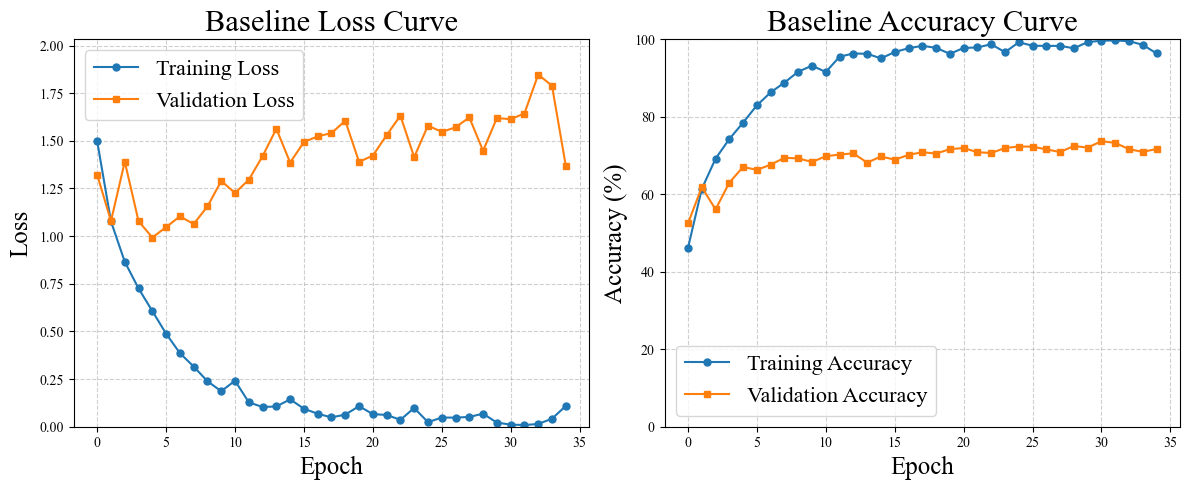

Plot saved as: plots\Baseline_metrics.png
Baseline Modle Validation Accuracy: 71.68%



In [14]:
# Step 1: Train Baseline Model
print("Training Baseline Model...")
model, optimizer, criterion = initialize_model(lr=0.001)
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(epoch_num):
    model.train()  # Set model to training mode
    train_loss, train_acc = train_one_epoch(model, trainloader, criterion, optimizer, device)
    
    model.eval()  # Set model to evaluation mode for validation
    with torch.no_grad():  # Disable gradient calculation for validation
        val_loss, val_acc = validate(model, valloader, criterion, device)

    # Record losses and accuracies
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{epoch_num}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Epoch [{epoch+1}/{epoch_num}], Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# Plot metrics for the baseline model
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, "Baseline")

# Save baseline model
torch.save(model.state_dict(), "baseline_model.pth")
print(f"Baseline Modle Validation Accuracy: {val_acc:.2f}%\n")


### Learning Rate Optimization


Finding Best Learning Rate...
Epoch [1/35], Train Loss: 2.2183, Train Acc: 24.52%
Epoch [1/35], Val Loss: 2.1845, Val Acc: 29.72%
Epoch [2/35], Train Loss: 1.6781, Train Acc: 40.18%
Epoch [2/35], Val Loss: 1.8736, Val Acc: 42.24%
Epoch [3/35], Train Loss: 1.4865, Train Acc: 46.66%
Epoch [3/35], Val Loss: 1.4060, Val Acc: 48.87%
Epoch [4/35], Train Loss: 1.2869, Train Acc: 53.82%
Epoch [4/35], Val Loss: 1.3026, Val Acc: 53.64%
Epoch [5/35], Train Loss: 1.1287, Train Acc: 59.52%
Epoch [5/35], Val Loss: 1.2398, Val Acc: 56.85%
Epoch [6/35], Train Loss: 1.0140, Train Acc: 64.01%
Epoch [6/35], Val Loss: 1.0704, Val Acc: 62.35%
Epoch [7/35], Train Loss: 0.8574, Train Acc: 69.44%
Epoch [7/35], Val Loss: 1.1699, Val Acc: 61.19%
Epoch [8/35], Train Loss: 0.8624, Train Acc: 69.42%
Epoch [8/35], Val Loss: 0.9157, Val Acc: 67.77%
Epoch [9/35], Train Loss: 0.7106, Train Acc: 75.03%
Epoch [9/35], Val Loss: 0.9958, Val Acc: 66.16%
Epoch [10/35], Train Loss: 0.6207, Train Acc: 78.16%
Epoch [10/35], V

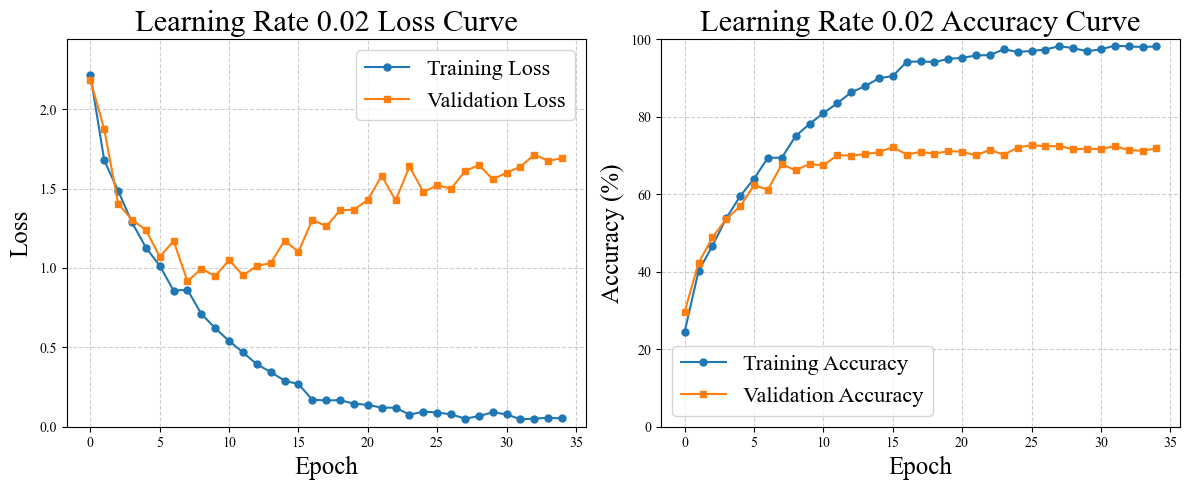

Plot saved as: plots\Learning_Rate_0.02_metrics.png
Epoch [1/35], Train Loss: 1.7754, Train Acc: 37.44%
Epoch [1/35], Val Loss: 1.4782, Val Acc: 47.81%
Epoch [2/35], Train Loss: 1.2613, Train Acc: 54.76%
Epoch [2/35], Val Loss: 1.3671, Val Acc: 52.59%
Epoch [3/35], Train Loss: 1.0357, Train Acc: 63.22%
Epoch [3/35], Val Loss: 1.2713, Val Acc: 56.38%
Epoch [4/35], Train Loss: 0.8917, Train Acc: 68.45%
Epoch [4/35], Val Loss: 1.0830, Val Acc: 61.74%
Epoch [5/35], Train Loss: 0.7625, Train Acc: 73.13%
Epoch [5/35], Val Loss: 0.8609, Val Acc: 69.92%
Epoch [6/35], Train Loss: 0.6573, Train Acc: 76.96%
Epoch [6/35], Val Loss: 0.9202, Val Acc: 69.29%
Epoch [7/35], Train Loss: 0.5712, Train Acc: 79.94%
Epoch [7/35], Val Loss: 0.8684, Val Acc: 70.64%
Epoch [8/35], Train Loss: 0.4748, Train Acc: 83.17%
Epoch [8/35], Val Loss: 0.9693, Val Acc: 69.59%
Epoch [9/35], Train Loss: 0.4340, Train Acc: 84.83%
Epoch [9/35], Val Loss: 0.8965, Val Acc: 71.73%
Epoch [10/35], Train Loss: 0.3396, Train Acc: 88

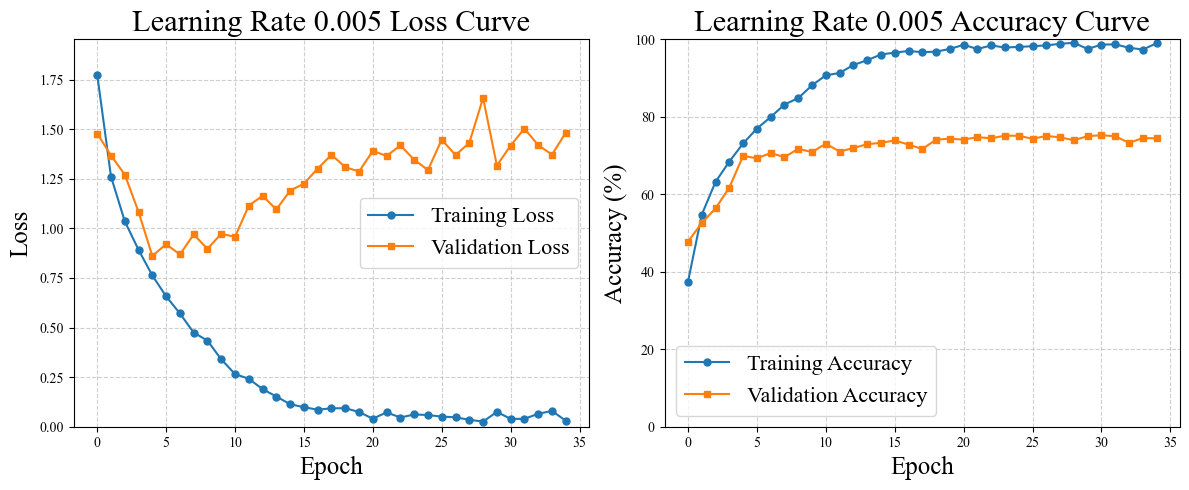

Plot saved as: plots\Learning_Rate_0.005_metrics.png
Epoch [1/35], Train Loss: 1.5469, Train Acc: 44.38%
Epoch [1/35], Val Loss: 1.3594, Val Acc: 51.30%
Epoch [2/35], Train Loss: 1.1126, Train Acc: 60.31%
Epoch [2/35], Val Loss: 1.1842, Val Acc: 58.57%
Epoch [3/35], Train Loss: 0.8816, Train Acc: 68.72%
Epoch [3/35], Val Loss: 1.1302, Val Acc: 60.69%
Epoch [4/35], Train Loss: 0.7094, Train Acc: 74.88%
Epoch [4/35], Val Loss: 1.1256, Val Acc: 62.44%
Epoch [5/35], Train Loss: 0.5366, Train Acc: 80.88%
Epoch [5/35], Val Loss: 1.1536, Val Acc: 64.42%
Epoch [6/35], Train Loss: 0.4167, Train Acc: 85.19%
Epoch [6/35], Val Loss: 1.3373, Val Acc: 61.78%
Epoch [7/35], Train Loss: 0.3076, Train Acc: 89.10%
Epoch [7/35], Val Loss: 1.3065, Val Acc: 64.54%
Epoch [8/35], Train Loss: 0.2348, Train Acc: 91.66%
Epoch [8/35], Val Loss: 1.4136, Val Acc: 64.58%
Epoch [9/35], Train Loss: 0.1839, Train Acc: 93.52%
Epoch [9/35], Val Loss: 1.5206, Val Acc: 65.32%
Epoch [10/35], Train Loss: 0.1470, Train Acc: 9

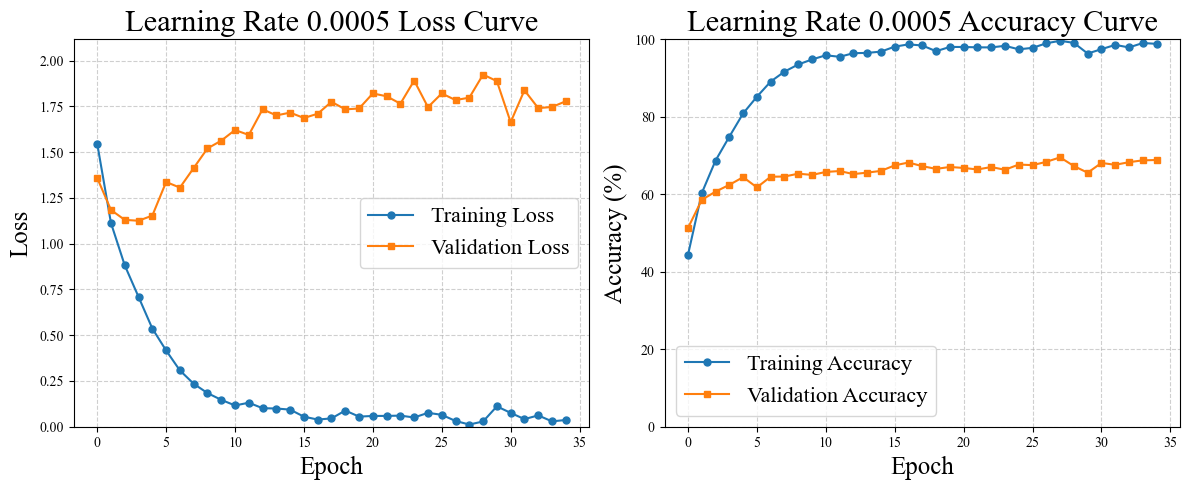

Plot saved as: plots\Learning_Rate_0.0005_metrics.png
Epoch [1/35], Train Loss: 1.7557, Train Acc: 36.59%
Epoch [1/35], Val Loss: 1.5078, Val Acc: 45.58%
Epoch [2/35], Train Loss: 1.2862, Train Acc: 54.34%
Epoch [2/35], Val Loss: 1.4114, Val Acc: 49.98%
Epoch [3/35], Train Loss: 1.0003, Train Acc: 65.35%
Epoch [3/35], Val Loss: 1.3900, Val Acc: 51.65%
Epoch [4/35], Train Loss: 0.7176, Train Acc: 76.98%
Epoch [4/35], Val Loss: 1.4464, Val Acc: 51.25%
Epoch [5/35], Train Loss: 0.4412, Train Acc: 87.78%
Epoch [5/35], Val Loss: 1.5944, Val Acc: 51.27%
Epoch [6/35], Train Loss: 0.2241, Train Acc: 95.17%
Epoch [6/35], Val Loss: 1.7488, Val Acc: 50.64%
Epoch [7/35], Train Loss: 0.0963, Train Acc: 98.86%
Epoch [7/35], Val Loss: 1.8703, Val Acc: 50.87%
Epoch [8/35], Train Loss: 0.0422, Train Acc: 99.78%
Epoch [8/35], Val Loss: 1.9537, Val Acc: 51.77%
Epoch [9/35], Train Loss: 0.0293, Train Acc: 99.86%
Epoch [9/35], Val Loss: 2.0479, Val Acc: 51.41%
Epoch [10/35], Train Loss: 0.0209, Train Acc: 

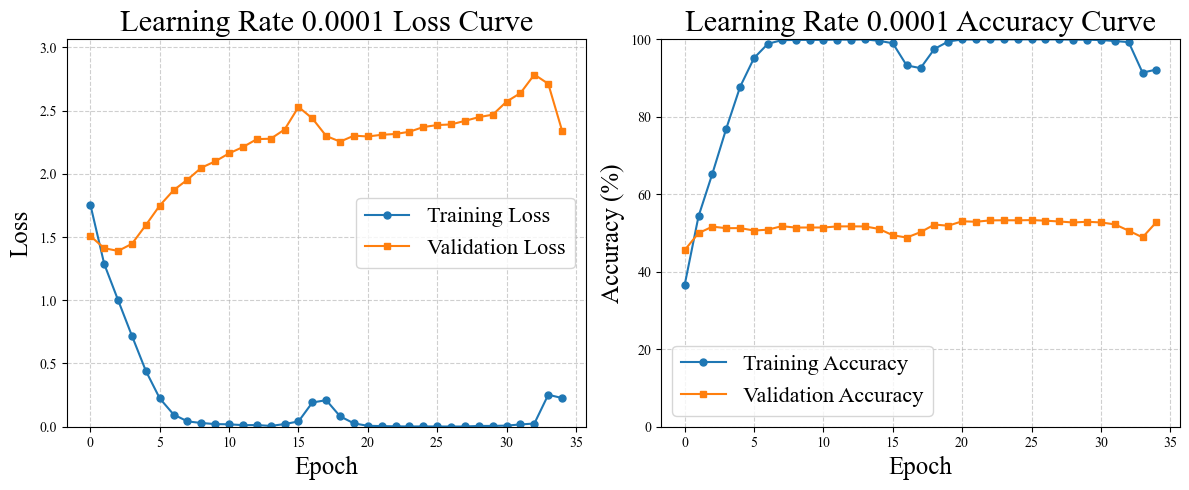

Plot saved as: plots\Learning_Rate_0.0001_metrics.png
Best learning rate: 0.005
Validation Accuracy: 74.44%



In [15]:
# Step 2: Independent Learning Rate Experiment
print("\nFinding Best Learning Rate...")
best_lr_model, best_val_acc, best_lr = None, 0.0, 0.001
for lr in [0.02, 0.005, 0.0005, 0.0001]:
    # Initialize a new model for each learning rate
    model, optimizer, criterion = initialize_model(lr=lr)  # Baseline Model with modified learning rate
    model = model.to(device)

    # Initialize fresh lists for metrics
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(epoch_num):
        # Set model to training mode
        model.train()
        train_loss, train_acc = train_one_epoch(model, trainloader, criterion, optimizer, device)
        
        # Set model to evaluation mode and disable gradients for validation
        model.eval()
        with torch.no_grad():
            val_loss, val_acc = validate(model, valloader, criterion, device)

        # Record losses and accuracies for each epoch
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        print(f"Epoch [{epoch+1}/{epoch_num}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Epoch [{epoch+1}/{epoch_num}], Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Plot metrics for this specific learning rate experiment
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, f"Learning Rate {lr}")

    # Save the best model based on validation accuracy
    if val_acc > best_val_acc:
        best_lr_model = model.state_dict()
        best_val_acc = val_acc
        best_lr = lr

print(f"Best learning rate: {best_lr}")
print(f"Validation Accuracy: {best_val_acc:.2f}%\n")

# Save the best model from the learning rate experiments
torch.save(best_lr_model, "best_lr_model.pth")


### Compare learning rates

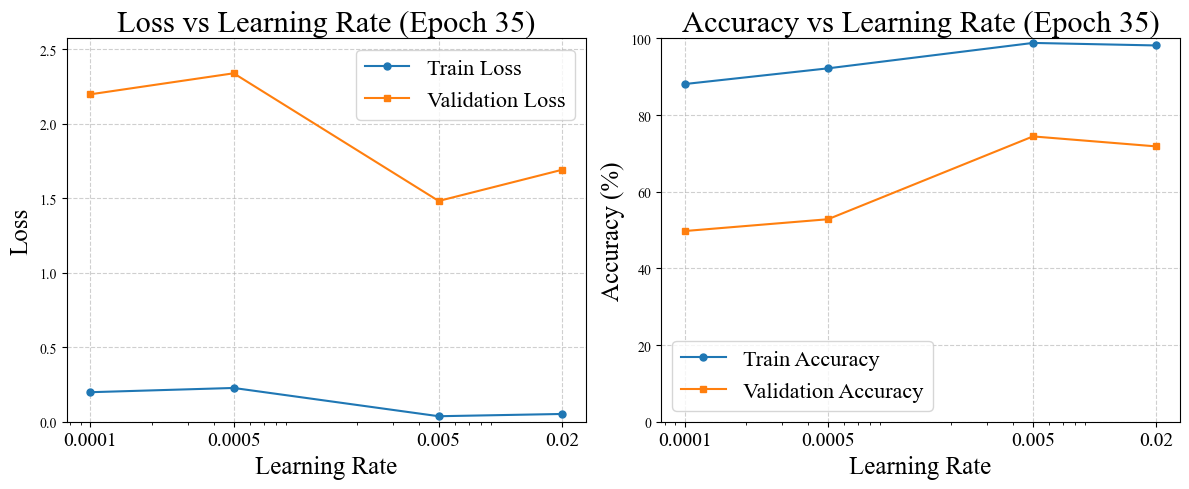

Plot saved as: plots\metrics_vs_learning_rate.png


In [37]:
import matplotlib.pyplot as plt
import os

# Define the save directory
save_dir = "plots"
os.makedirs(save_dir, exist_ok=True)

# Learning rate list and corresponding final (Epoch 35) metrics
learning_rates = [0.02, 0.005, 0.0005, 0.0001]

# Metrics for each learning rate at Epoch 35
train_losses = [0.0521, 0.0369, 0.2267, 0.1982]
val_losses = [1.6918, 1.4823, 2.3397, 2.1985]
train_accuracies = [98.17, 98.83, 92.20, 88.10]
val_accuracies = [71.83, 74.44, 52.83, 49.75]

# Set font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# Create the figure
plt.figure(figsize=(12, 5))

# Left subplot - Loss curve
plt.subplot(1, 2, 1)
plt.plot(learning_rates, train_losses, label='Train Loss', linestyle='-', marker='o', markersize=5)
plt.plot(learning_rates, val_losses, label='Validation Loss', linestyle='-', marker='s', markersize=5)
plt.xlabel('Learning Rate', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.ylim(0, max(max(train_losses), max(val_losses)) * 1.1)
plt.xscale('log')  # Set learning rate to logarithmic scale
plt.xticks(learning_rates, [str(lr) for lr in learning_rates], fontsize=14)  # Set font size of x-axis ticks
plt.legend(fontsize=16)
plt.title('Loss vs Learning Rate (Epoch 35)', fontsize=22)
plt.grid(True, linestyle='--', alpha=0.6)

# Right subplot - Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(learning_rates, train_accuracies, label='Train Accuracy', linestyle='-', marker='o', markersize=5)
plt.plot(learning_rates, val_accuracies, label='Validation Accuracy', linestyle='-', marker='s', markersize=5)
plt.xlabel('Learning Rate', fontsize=18)
plt.ylabel('Accuracy (%)', fontsize=18)
plt.ylim(0, 100)
plt.xscale('log')  # Set learning rate to logarithmic scale
plt.xticks(learning_rates, [str(lr) for lr in learning_rates], fontsize=14)  # Set font size of x-axis ticks
plt.legend(fontsize=16)
plt.title('Accuracy vs Learning Rate (Epoch 35)', fontsize=22)
plt.grid(True, linestyle='--', alpha=0.6)

# Adjust layout
plt.tight_layout()

# Save the plot in high resolution
save_path = os.path.join(save_dir, "metrics_vs_learning_rate.png")
plt.savefig(save_path, dpi=300, format='png', bbox_inches='tight')  # Save as PNG with specified DPI

# Show the plot
plt.show()

print(f"Plot saved as: {save_path}")


### L2 vs Dropout

In [16]:
best_lr = 0.005  # Best learning rate found in the previous experiment


Evaluating Regularization (L2 vs Dropout)...
Epoch [1/35], Train Loss: 1.7333, Train Acc: 38.86%
Epoch [1/35], Val Loss: 1.4470, Val Acc: 45.72%
Epoch [2/35], Train Loss: 1.2640, Train Acc: 54.04%
Epoch [2/35], Val Loss: 1.5367, Val Acc: 53.88%
Epoch [3/35], Train Loss: 1.0417, Train Acc: 62.83%
Epoch [3/35], Val Loss: 1.1197, Val Acc: 60.38%
Epoch [4/35], Train Loss: 0.8895, Train Acc: 68.47%
Epoch [4/35], Val Loss: 1.0878, Val Acc: 63.81%
Epoch [5/35], Train Loss: 0.7671, Train Acc: 73.14%
Epoch [5/35], Val Loss: 0.9202, Val Acc: 67.63%
Epoch [6/35], Train Loss: 0.6709, Train Acc: 76.34%
Epoch [6/35], Val Loss: 0.8671, Val Acc: 70.57%
Epoch [7/35], Train Loss: 0.5505, Train Acc: 80.63%
Epoch [7/35], Val Loss: 0.8949, Val Acc: 70.43%
Epoch [8/35], Train Loss: 0.4970, Train Acc: 82.50%
Epoch [8/35], Val Loss: 0.8492, Val Acc: 71.89%
Epoch [9/35], Train Loss: 0.3926, Train Acc: 86.37%
Epoch [9/35], Val Loss: 0.9216, Val Acc: 71.20%
Epoch [10/35], Train Loss: 0.3482, Train Acc: 87.68%
E

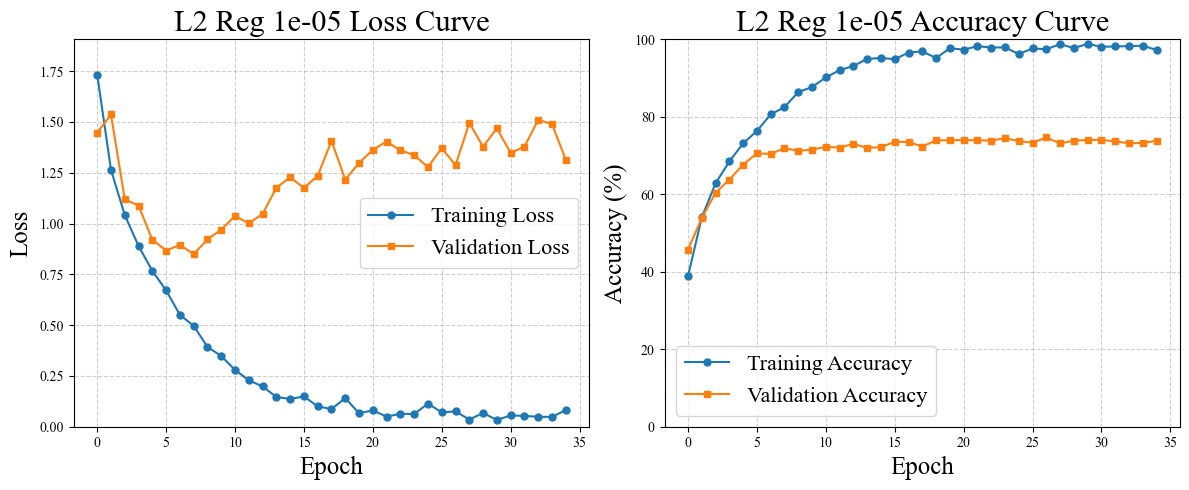

Plot saved as: plots\L2_Reg_1e-05_metrics.png
Epoch [1/35], Train Loss: 1.7553, Train Acc: 37.59%
Epoch [1/35], Val Loss: 1.4616, Val Acc: 45.73%
Epoch [2/35], Train Loss: 1.2790, Train Acc: 53.73%
Epoch [2/35], Val Loss: 1.3517, Val Acc: 52.83%
Epoch [3/35], Train Loss: 1.0693, Train Acc: 61.81%
Epoch [3/35], Val Loss: 1.1928, Val Acc: 58.69%
Epoch [4/35], Train Loss: 0.9238, Train Acc: 67.38%
Epoch [4/35], Val Loss: 0.9984, Val Acc: 65.02%
Epoch [5/35], Train Loss: 0.7947, Train Acc: 72.10%
Epoch [5/35], Val Loss: 1.0484, Val Acc: 64.75%
Epoch [6/35], Train Loss: 0.7008, Train Acc: 75.59%
Epoch [6/35], Val Loss: 0.9979, Val Acc: 66.88%
Epoch [7/35], Train Loss: 0.6372, Train Acc: 77.79%
Epoch [7/35], Val Loss: 1.1082, Val Acc: 62.66%
Epoch [8/35], Train Loss: 0.5729, Train Acc: 79.93%
Epoch [8/35], Val Loss: 0.9030, Val Acc: 70.38%
Epoch [9/35], Train Loss: 0.4717, Train Acc: 83.58%
Epoch [9/35], Val Loss: 0.9348, Val Acc: 69.35%
Epoch [10/35], Train Loss: 0.4410, Train Acc: 84.74%
E

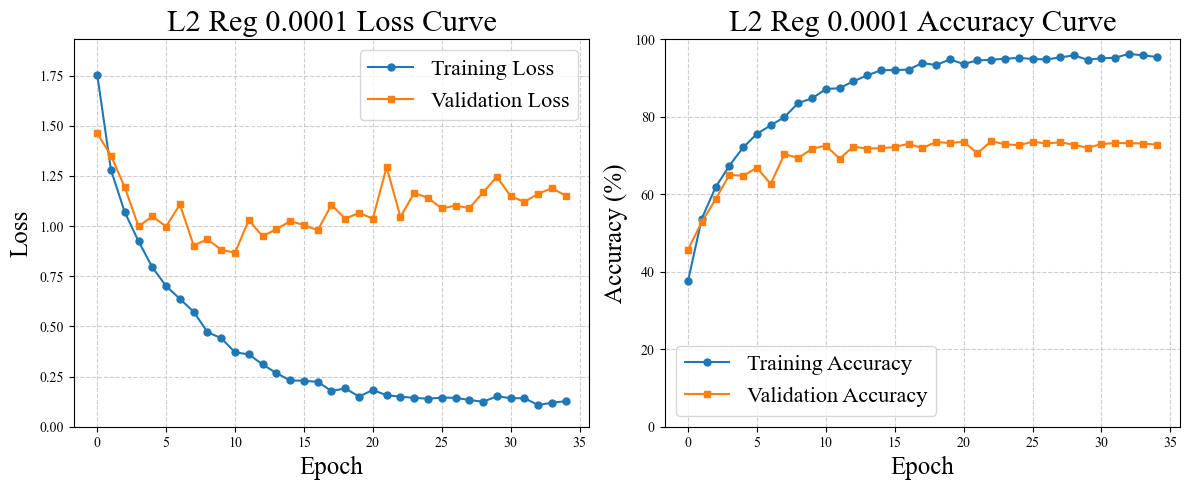

Plot saved as: plots\L2_Reg_0.0001_metrics.png
Epoch [1/35], Train Loss: 1.7350, Train Acc: 37.92%
Epoch [1/35], Val Loss: 1.8708, Val Acc: 34.37%
Epoch [2/35], Train Loss: 1.2657, Train Acc: 54.46%
Epoch [2/35], Val Loss: 1.3179, Val Acc: 52.97%
Epoch [3/35], Train Loss: 1.0779, Train Acc: 61.39%
Epoch [3/35], Val Loss: 1.3866, Val Acc: 50.46%
Epoch [4/35], Train Loss: 0.9677, Train Acc: 66.21%
Epoch [4/35], Val Loss: 1.2714, Val Acc: 56.12%
Epoch [5/35], Train Loss: 0.9068, Train Acc: 68.44%
Epoch [5/35], Val Loss: 1.1981, Val Acc: 58.52%
Epoch [6/35], Train Loss: 0.8361, Train Acc: 70.99%
Epoch [6/35], Val Loss: 1.0103, Val Acc: 64.49%
Epoch [7/35], Train Loss: 0.7792, Train Acc: 73.26%
Epoch [7/35], Val Loss: 1.0612, Val Acc: 64.14%
Epoch [8/35], Train Loss: 0.7478, Train Acc: 74.47%
Epoch [8/35], Val Loss: 1.0244, Val Acc: 65.22%
Epoch [9/35], Train Loss: 0.7204, Train Acc: 75.19%
Epoch [9/35], Val Loss: 1.0046, Val Acc: 65.50%
Epoch [10/35], Train Loss: 0.7013, Train Acc: 75.91%


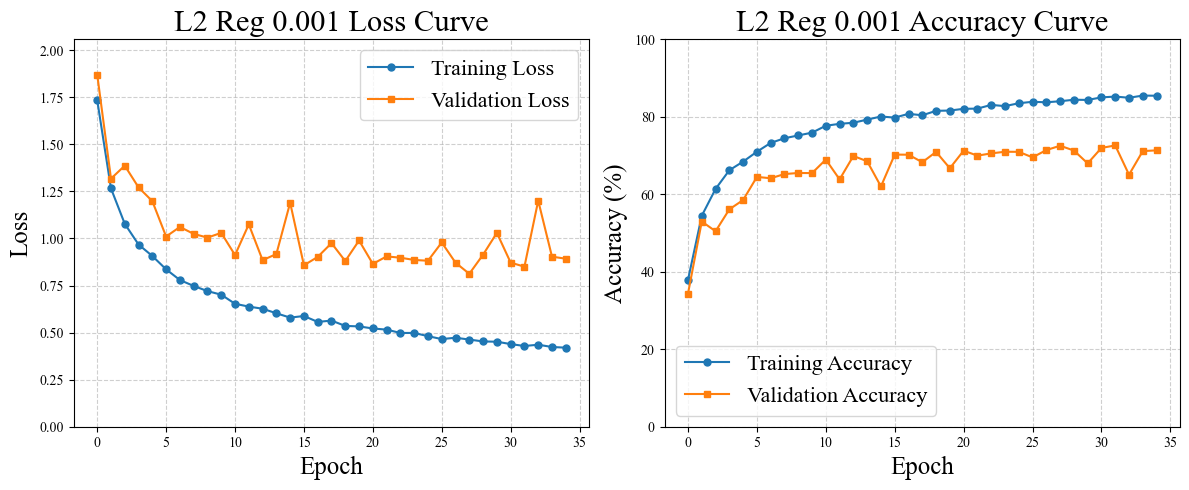

Plot saved as: plots\L2_Reg_0.001_metrics.png
Best L2 Regularisation: weight_decay=1e-05
L2 Regularisation Validation Accuracy: 73.79%



In [19]:
# Step 3: Regularization Experiment (L2 vs Dropout)
print("\nEvaluating Regularization (L2 vs Dropout)...")
best_l2_model, best_l2_acc, best_l2 = None, 0.0, "None"

# L2 Regularization
for wd in [1e-5, 0.0001, 0.001]:
    model, optimizer, criterion = initialize_model(lr=best_lr, weight_decay=wd)
    model = model.to(device)
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(epoch_num):
        # Training phase
        model.train()
        train_loss, train_acc = train_one_epoch(model, trainloader, criterion, optimizer, device)
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            val_loss, val_acc = validate(model, valloader, criterion, device)

        # Record losses and accuracies
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        print(f"Epoch [{epoch+1}/{epoch_num}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Epoch [{epoch+1}/{epoch_num}], Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Plot metrics for this L2 regularization experiment
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, f"L2 Reg {wd}")

    # Save the best L2 regularized model based on validation accuracy
    if val_acc > best_l2_acc:
        best_l2_model = model.state_dict()
        best_l2_acc = val_acc
        best_l2 = f"weight_decay={wd}"

print(f"Best L2 Regularisation: {best_l2}")
print(f"L2 Regularisation Validation Accuracy: {best_l2_acc:.2f}%\n")

# Save the best model from the L2 experiments
torch.save(best_l2_model, "best_l2_model.pth")


Epoch [1/35], Train Loss: 1.7772, Train Acc: 37.02%
Epoch [1/35], Val Loss: 1.5167, Val Acc: 45.30%
Epoch [2/35], Train Loss: 1.2793, Train Acc: 53.59%
Epoch [2/35], Val Loss: 1.2961, Val Acc: 53.21%
Epoch [3/35], Train Loss: 1.0602, Train Acc: 62.45%
Epoch [3/35], Val Loss: 1.1362, Val Acc: 61.04%
Epoch [4/35], Train Loss: 0.9064, Train Acc: 67.95%
Epoch [4/35], Val Loss: 1.0383, Val Acc: 64.20%
Epoch [5/35], Train Loss: 0.7687, Train Acc: 72.75%
Epoch [5/35], Val Loss: 0.9805, Val Acc: 66.61%
Epoch [6/35], Train Loss: 0.6758, Train Acc: 76.14%
Epoch [6/35], Val Loss: 1.0279, Val Acc: 65.70%
Epoch [7/35], Train Loss: 0.5782, Train Acc: 79.84%
Epoch [7/35], Val Loss: 0.9711, Val Acc: 67.67%
Epoch [8/35], Train Loss: 0.5134, Train Acc: 82.04%
Epoch [8/35], Val Loss: 0.9004, Val Acc: 71.05%
Epoch [9/35], Train Loss: 0.4210, Train Acc: 85.23%
Epoch [9/35], Val Loss: 0.9065, Val Acc: 71.16%
Epoch [10/35], Train Loss: 0.3478, Train Acc: 87.97%
Epoch [10/35], Val Loss: 0.9233, Val Acc: 72.48

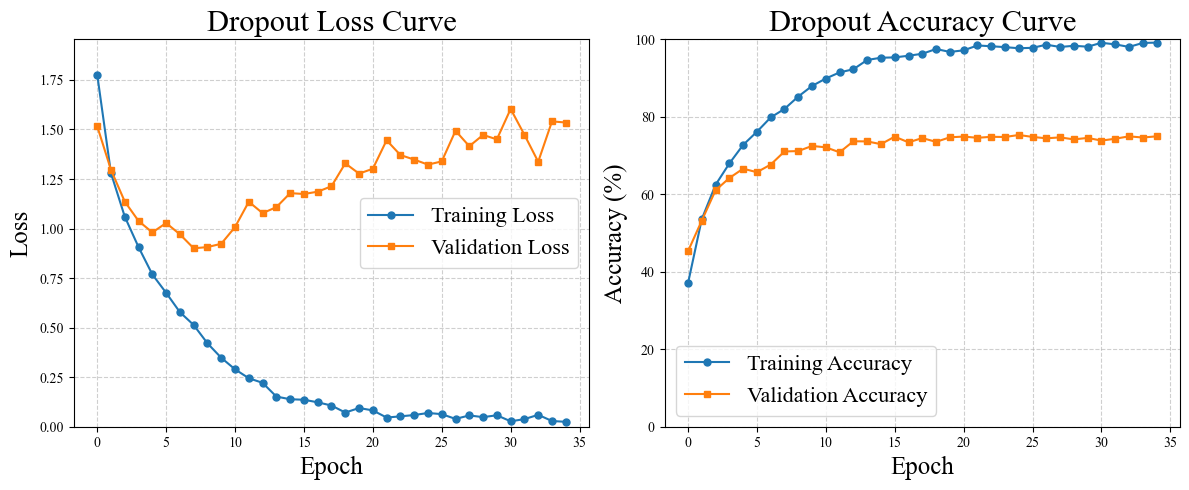

Plot saved as: plots\Dropout_metrics.png
Dropout Model Validation Accuracy: 74.96%



In [20]:
import time
# Dropout
# Set the seed before each training session
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
class ResNet18WithDropout(models.ResNet):
    def __init__(self, dropout_rate=0.2):
        super(ResNet18WithDropout, self).__init__(block=models.resnet.BasicBlock, layers=[2, 2, 2, 2])
        self.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.fc.in_features, 10)
        )

model = ResNet18WithDropout().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_lr)
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

# Training Time Start
start_time = time.time()
for epoch in range(epoch_num):
    train_loss, train_acc = train_one_epoch(model, trainloader, criterion, optimizer, device)
    # Set model to evaluation mode during validation to disable dropout
    model.eval()
    with torch.no_grad():
        val_loss, val_acc = validate(model, valloader, criterion, device)
    model.train()  # Set back to training mode after validation
    
    # Record metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print(f"Epoch [{epoch+1}/{epoch_num}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Epoch [{epoch+1}/{epoch_num}], Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# Compute training time
resnet18_training_time = time.time() - start_time
print(f"Total Training Time: {resnet18_training_time:.2f} seconds")

# Count number of parameters
resnet18_num_params = sum(p.numel() for p in model.parameters()) / 1e6  # convert to "million" unit
print(f"Model Size (Million parameters): {resnet18_num_params:.2f}M")

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, "Dropout")
dropout_model = model.state_dict()
torch.save(dropout_model, "dropout_model.pth")
print(f"Dropout Model Validation Accuracy: {val_acc:.2f}%\n")

### Compare Regularisation and Dropout

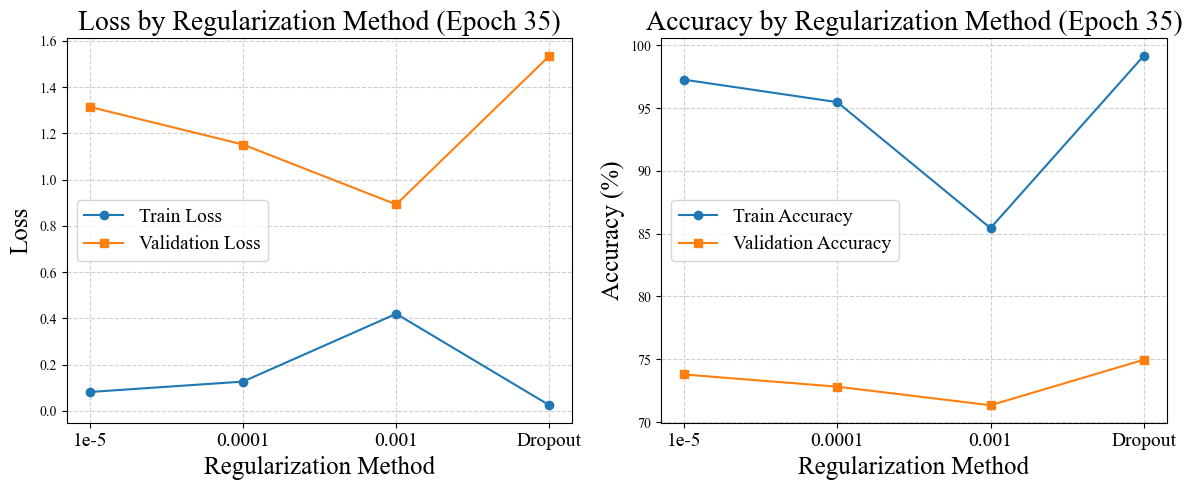

Plot saved as: plots\regularization_comparison_epoch_35.png


In [36]:
import matplotlib.pyplot as plt
import os

# Define save directory for plots
save_dir = "plots"
os.makedirs(save_dir, exist_ok=True)

# Regularization methods and corresponding metrics at Epoch 35
regularizations = ["1e-5", "0.0001", "0.001", "Dropout"]
train_losses = [0.0821, 0.1270, 0.4200, 0.0248]
val_losses = [1.3143, 1.1516, 0.8925, 1.5350]
train_accuracies = [97.26, 95.47, 85.44, 99.16]
val_accuracies = [73.79, 72.82, 71.34, 74.96]

# Set font to Times New Roman for academic style
plt.rcParams['font.family'] = 'Times New Roman'

# Create figure for Loss and Accuracy plots
plt.figure(figsize=(12, 5))

# Left subplot - Loss for each regularization method
plt.subplot(1, 2, 1)
plt.plot(regularizations, train_losses, label='Train Loss', linestyle='-', marker='o', markersize=6)
plt.plot(regularizations, val_losses, label='Validation Loss', linestyle='-', marker='s', markersize=6)
plt.xlabel('Regularization Method', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.xticks(regularizations, fontsize=14)  # Set x-axis tick labels
plt.legend(fontsize=14)
plt.title('Loss by Regularization Method (Epoch 35)', fontsize=20)
plt.grid(True, linestyle='--', alpha=0.6)

# Right subplot - Accuracy for each regularization method
plt.subplot(1, 2, 2)
plt.plot(regularizations, train_accuracies, label='Train Accuracy', linestyle='-', marker='o', markersize=6)
plt.plot(regularizations, val_accuracies, label='Validation Accuracy', linestyle='-', marker='s', markersize=6)
plt.xlabel('Regularization Method', fontsize=18)
plt.ylabel('Accuracy (%)', fontsize=18)
plt.xticks(regularizations, fontsize=14)  # Set x-axis tick labels
plt.legend(fontsize=14)
plt.title('Accuracy by Regularization Method (Epoch 35)', fontsize=20)
plt.grid(True, linestyle='--', alpha=0.6)

# Adjust layout for readability
plt.tight_layout()

# Save the plot in high resolution
save_path = os.path.join(save_dir, "regularization_comparison_epoch_35.png")
plt.savefig(save_path, dpi=300, format='png', bbox_inches='tight')

# Display the plot
plt.show()

print(f"Plot saved as: {save_path}")


## Using SGD as optimizer

Epoch [1/35], Train Loss: 1.8114, Train Acc: 34.32%
Epoch [1/35], Val Loss: 1.5167, Val Acc: 46.41%
Epoch [2/35], Train Loss: 1.3717, Train Acc: 50.36%
Epoch [2/35], Val Loss: 1.3358, Val Acc: 51.96%
Epoch [3/35], Train Loss: 1.1673, Train Acc: 58.03%
Epoch [3/35], Val Loss: 1.2773, Val Acc: 54.44%
Epoch [4/35], Train Loss: 0.9993, Train Acc: 64.39%
Epoch [4/35], Val Loss: 1.2616, Val Acc: 56.12%
Epoch [5/35], Train Loss: 0.8407, Train Acc: 70.26%
Epoch [5/35], Val Loss: 1.2665, Val Acc: 57.45%
Epoch [6/35], Train Loss: 0.6781, Train Acc: 76.31%
Epoch [6/35], Val Loss: 1.3190, Val Acc: 57.98%
Epoch [7/35], Train Loss: 0.5349, Train Acc: 81.52%
Epoch [7/35], Val Loss: 1.3796, Val Acc: 58.18%
Epoch [8/35], Train Loss: 0.4203, Train Acc: 85.28%
Epoch [8/35], Val Loss: 1.5167, Val Acc: 57.63%
Epoch [9/35], Train Loss: 0.3005, Train Acc: 89.75%
Epoch [9/35], Val Loss: 1.6611, Val Acc: 58.00%
Epoch [10/35], Train Loss: 0.2478, Train Acc: 91.39%
Epoch [10/35], Val Loss: 1.7133, Val Acc: 57.71

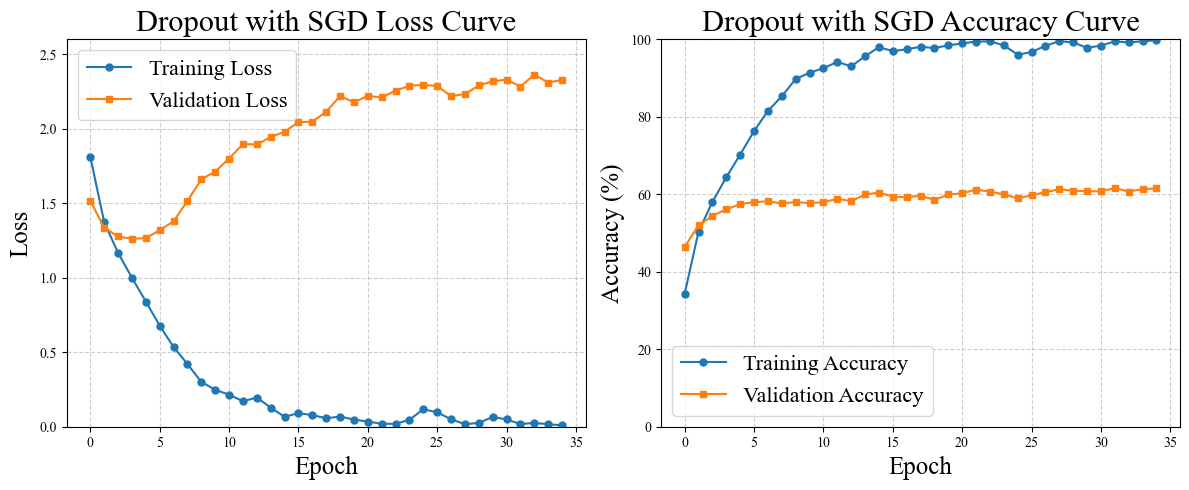

Plot saved as: plots\Dropout_with_SGD_metrics.png
Dropout Model with SGD Validation Accuracy: 61.54%



In [31]:
# Dropout with SGD Optimizer
# Set the seed before each training session
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

model = ResNet18WithDropout().to(device)

# Use SGD with the same learning rate and weight decay as the previous Adam experiment
optimizer = optim.SGD(model.parameters(), lr=best_lr, momentum=0.9)
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(epoch_num):
    # Train
    train_loss, train_acc = train_one_epoch(model, trainloader, criterion, optimizer, device)
    
    # Validation with model in evaluation mode
    model.eval()
    with torch.no_grad():
        val_loss, val_acc = validate(model, valloader, criterion, device)
    model.train()  # Set back to training mode after validation
    
    # Record metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print(f"Epoch [{epoch+1}/{epoch_num}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Epoch [{epoch+1}/{epoch_num}], Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# Plot metrics
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, "Dropout with SGD")
torch.save(model.state_dict(), "dropout_model_sgd.pth")
print(f"Dropout Model with SGD Validation Accuracy: {val_acc:.2f}%\n")

## Optimal Model Test Accuracy Report

In [21]:
# Reinitialize the model with the same architecture as the saved best model
best_dropout_model = ResNet18WithDropout().to(device)  # Use best model's class and parameters
# Load the saved state dictionary
best_dropout_model.load_state_dict(torch.load("dropout_model.pth"))
# Set model to evaluation mode
with torch.no_grad():
    best_dropout_model.eval()
    # Perform the final evaluation on the test set
    resnet18_test_loss, resnet18_test_acc = validate(best_dropout_model, testloader, criterion, device)
print(f"Test Accuracy of Best Model: {resnet18_test_acc:.2f}%")

C:\Users\Lucia\AppData\Local\Temp\ipykernel_6852\3376747507.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_dropout_model.load_state_dict(torch.load("dropout_model.

Test Accuracy of Best Model: 74.06%


# AlexNet (Modified Architecture)

Epoch [1/35], Train Loss: 1.9527, Train Acc: 25.09%
Epoch [1/35], Val Loss: 1.6753, Val Acc: 35.94%
Epoch [2/35], Train Loss: 1.4860, Train Acc: 44.05%
Epoch [2/35], Val Loss: 1.3683, Val Acc: 48.97%
Epoch [3/35], Train Loss: 1.2494, Train Acc: 54.30%
Epoch [3/35], Val Loss: 1.1729, Val Acc: 57.50%
Epoch [4/35], Train Loss: 1.0788, Train Acc: 60.90%
Epoch [4/35], Val Loss: 1.0238, Val Acc: 62.99%
Epoch [5/35], Train Loss: 0.9319, Train Acc: 66.68%
Epoch [5/35], Val Loss: 0.9654, Val Acc: 65.44%
Epoch [6/35], Train Loss: 0.8128, Train Acc: 71.09%
Epoch [6/35], Val Loss: 0.8841, Val Acc: 68.71%
Epoch [7/35], Train Loss: 0.7105, Train Acc: 74.70%
Epoch [7/35], Val Loss: 0.8173, Val Acc: 71.27%
Epoch [8/35], Train Loss: 0.6260, Train Acc: 77.92%
Epoch [8/35], Val Loss: 1.0658, Val Acc: 66.08%
Epoch [9/35], Train Loss: 0.5652, Train Acc: 80.33%
Epoch [9/35], Val Loss: 0.7841, Val Acc: 73.66%
Epoch [10/35], Train Loss: 0.5015, Train Acc: 82.19%
Epoch [10/35], Val Loss: 0.7444, Val Acc: 74.80

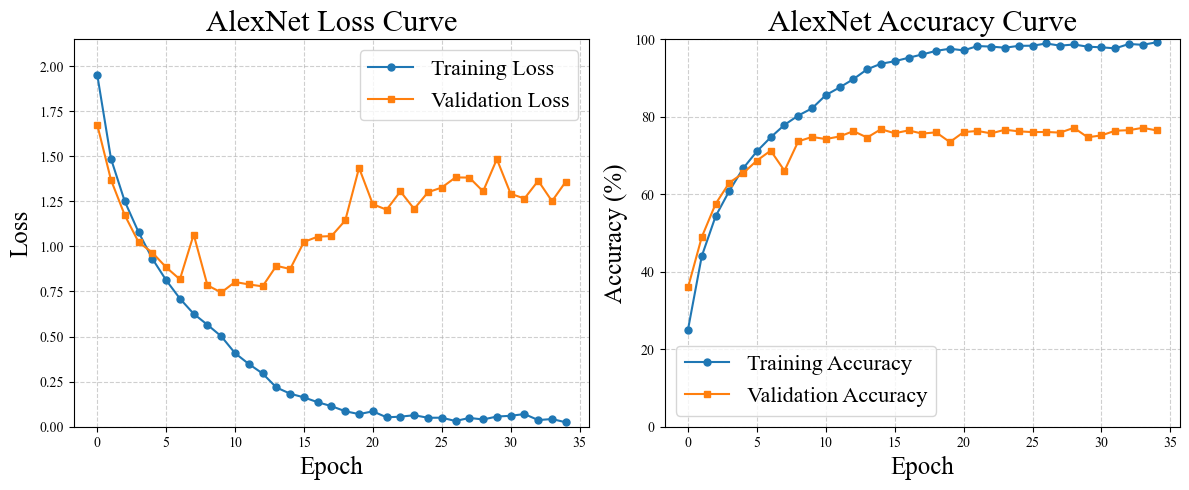

Plot saved as: plots\AlexNet_metrics.png
Test Accuracy of AlexNet Model: 76.35%


In [25]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Define AlexNet model for CIFAR-10 (without Dropout)
class AlexNetForCIFAR10(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNetForCIFAR10, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # CIFAR-10 input image size is 32x32
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 4 * 4)  # Flattening operation
        x = self.classifier(x)
        return x

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet_model = AlexNetForCIFAR10(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet_model.parameters(), lr=1e-3, weight_decay=1e-4)

# Training and validation functions
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Begin training and validation
epochs = 35
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

# Record the start time of training
start_time = time.time()

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(alexnet_model, trainloader, criterion, optimizer, device)
    val_loss, val_acc = validate(alexnet_model, valloader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Epoch [{epoch+1}/{epochs}], Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# Calculate total training time
alexnet_training_time = time.time() - start_time
print(f"Total Training Time: {alexnet_training_time:.2f} seconds")

# Calculate the number of model parameters
alexnet_num_params = sum(p.numel() for p in alexnet_model.parameters()) / 1e6  # Convert to millions
print(f"Model Size (Million parameters): {alexnet_num_params:.2f}M")

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, "AlexNet")

# Evaluate on the test set
alexnet_test_loss, alexnet_test_acc = validate(alexnet_model, testloader, criterion, device)
print(f"Test Accuracy of AlexNet Model: {alexnet_test_acc:.2f}%")


# MobileNet

Using device: cuda
Epoch [1/35], Train Loss: 2.1028, Train Acc: 24.61%
Epoch [1/35], Val Loss: 2.1803, Val Acc: 18.99%
Epoch [2/35], Train Loss: 1.6933, Train Acc: 35.46%
Epoch [2/35], Val Loss: 1.8681, Val Acc: 28.75%
Epoch [3/35], Train Loss: 1.5287, Train Acc: 42.90%
Epoch [3/35], Val Loss: 1.6574, Val Acc: 38.66%
Epoch [4/35], Train Loss: 1.3610, Train Acc: 50.35%
Epoch [4/35], Val Loss: 1.5775, Val Acc: 43.54%
Epoch [5/35], Train Loss: 1.2428, Train Acc: 55.31%
Epoch [5/35], Val Loss: 1.3138, Val Acc: 53.08%
Epoch [6/35], Train Loss: 1.1434, Train Acc: 59.09%
Epoch [6/35], Val Loss: 1.2780, Val Acc: 56.06%
Epoch [7/35], Train Loss: 1.0567, Train Acc: 62.85%
Epoch [7/35], Val Loss: 1.2277, Val Acc: 57.26%
Epoch [8/35], Train Loss: 1.0020, Train Acc: 64.82%
Epoch [8/35], Val Loss: 1.1059, Val Acc: 60.88%
Epoch [9/35], Train Loss: 0.9365, Train Acc: 67.25%
Epoch [9/35], Val Loss: 1.1226, Val Acc: 60.45%
Epoch [10/35], Train Loss: 0.8787, Train Acc: 69.10%
Epoch [10/35], Val Loss: 1.1

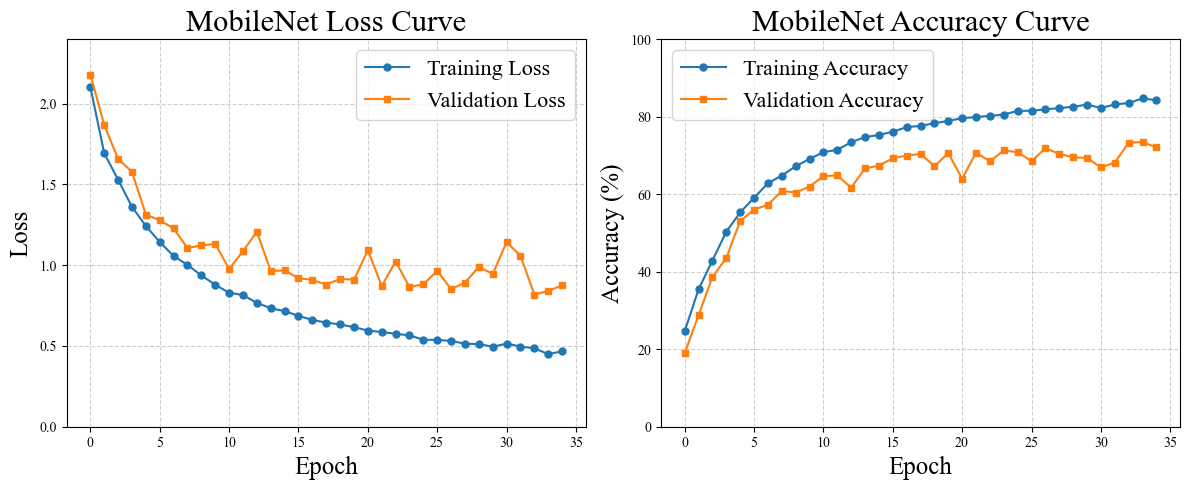

Plot saved as: plots\MobileNet_metrics.png
Test Accuracy of MobileNet Model: 71.69%
Training Time of MobileNet Model: 106.37 seconds
MobileNet Model Size (Million parameters): 2.24M parameters


In [29]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
# Set random seed for reproducibility
torch.manual_seed(42) # Ensures that the random number sequence generated with torch is repeatable

# Define device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)  # if use multi gpus

# Define MobileNet model with default parameters
mobilenet_model = models.mobilenet_v2(pretrained=False, num_classes=10).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_model.parameters(), lr=1e-2, weight_decay=1e-4)

# Training and validation functions
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Train MobileNet model
epoch_num = 35
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

start_time = time.time()  # Record start time of training
for epoch in range(epoch_num):
    train_loss, train_acc = train_one_epoch(mobilenet_model, trainloader, criterion, optimizer, device)
    val_loss, val_acc = validate(mobilenet_model, valloader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{epoch_num}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Epoch [{epoch+1}/{epoch_num}], Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

mobilenet_training_time = time.time() - start_time  # Record total training time

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, "MobileNet")

# Evaluate MobileNet model performance on test set
with torch.no_grad():
    mobilenet_model.eval()
    mobilenet_test_loss, mobilenet_test_acc = validate(mobilenet_model, testloader, criterion, device)

print(f"Test Accuracy of MobileNet Model: {mobilenet_test_acc:.2f}%")
print(f"Training Time of MobileNet Model: {mobilenet_training_time:.2f} seconds")

# Compare model size
mobilenet_size = sum(p.numel() for p in mobilenet_model.parameters()) / 1e6  # Calculate model size (millions of parameters)
print(f"MobileNet Model Size (Million parameters): {mobilenet_size:.2f}M parameters")

## Performance Summary

In [30]:
# Test Accuracy|Training Time|Model Size(Measured by number of million parameters)
# Record Results for comparison
results = {
    "Model": ["ResNet-18", "AlexNet", "MobileNetV2"],
    "Test Accuracy (%)": [resnet18_test_acc, alexnet_test_acc, mobilenet_test_acc],
    "Training Time (seconds)": [resnet18_training_time, alexnet_training_time, mobilenet_training_time], 
    "Model Size (M parameters)": [resnet18_num_params, alexnet_num_params, mobilenet_size]
}

# Output Table
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

         Model  Test Accuracy (%)  Training Time (seconds)  \
0    ResNet-18              74.06                67.608356   
1      AlexNet              76.35               173.241854   
2  MobileNetV2              71.69               106.374862   

   Model Size (M parameters)  
0                  11.181642  
1                  35.855178  
2                   2.236682  
